# PyTorch Computer Vision

* See reference notebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/03_pytorch_computer_vision.ipynb 
* See reference online book - https://www.learnpytorch.io/03_pytorch_computer_vision/

## 0. Computer vision libaries in PyTorch

* [`torchvision`](https://www.learnpytorch.io/03_pytorch_computer_vision/) - base domain library for PyTorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for computer vision here
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
* `torchvision.transforms` - functions for manipulating your vision data (images) to be suitable for use with an ML model
* `torch.utils.data.Dataset` - Base dataset class for PyTorch.
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset

In [1]:
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.4.0+cpu
0.19.0+cpu


## 1. Getting a dataset

The dataset we'll be using is FashionMNIST from torchvision.datasets - https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST 

In [2]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # do we want the training dataset?
    download=True, # should we download the data?
    transform=torchvision.transforms.ToTensor(), # how do we want to transform the data?
    target_transform=None # how do we want to transform the labels/target?
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
# See the first training example
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [5]:
class_names = train_data.classes

In [6]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

### 1.1 Check input and output shapes of data

In [7]:
# Check the shape of the image
print(f"Image shape: {image.shape} -> [color channel, height, width]")
print(f"Image Label: {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color channel, height, width]
Image Label: Ankle boot


### 1.1 Visualizing our data

Image shape: torch.Size([1, 28, 28])


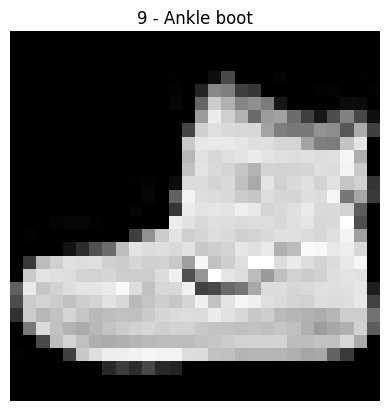

In [8]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(), cmap='gray')
plt.title(str(label) + " - " + class_names[label])
plt.axis('off');

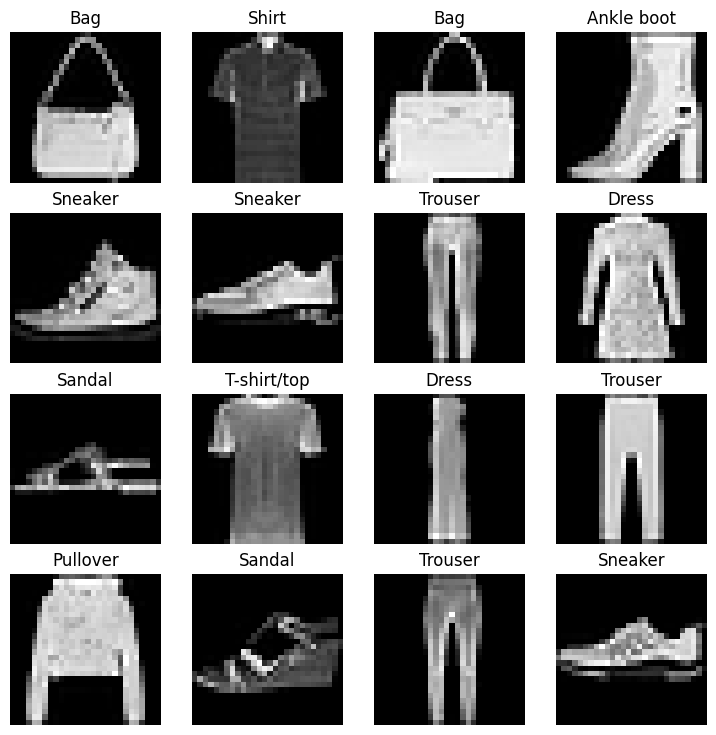

In [9]:
# Plot more images
# torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, columns = 4, 4
for i in range(1, rows*columns+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis('off')

Do you think these items of clothing (images) could be modelled with pure linear lines? Or do you think we'll need non-linearities?

In [10]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

## 2. Prepare DataLoader

Right now, our data is in the form of PyTorch Datasets.

DataLoader turns our dataset into a Python iterable.

More specifically, we want to turn our data into batches (or mini-batches).

Why would we do this?

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memory) at 60000 images in one hit. So we break it down to 32 images at a time (batch size of 32). 
2. It gives our neural network more chances to update its gradients per epoch.

For more on mini-batches, see here: https://youtu.be/l4lSUAcvHFs

In [11]:
# Turn train dataset into DatLoader
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [12]:
# Let's check out what we've created
print(f"DataLoaders: {train_dataloader}, {test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")

DataLoaders: <torch.utils.data.dataloader.DataLoader object at 0x0000010E6666C370>, <torch.utils.data.dataloader.DataLoader object at 0x0000010E66C2AB80>
Length of train_dataloader: 1875 batches of 32...
Length of test_dataloader: 313 batches of 32...


In [13]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 5, label size: torch.Size([])


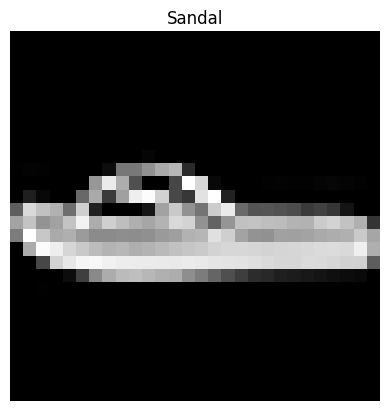

In [14]:
# Show a sample
# torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Model 0: Build a basline model

When starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline model.

A baseline model is a simple model you will try and improve upon with subsequent models/experiments.

In other words: start simply and add complexity when necessary.

In [15]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")


Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [16]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [17]:
torch.manual_seed(42)

# Setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape= 28*28,
    hidden_units=10,
    output_shape=len(class_names)
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [18]:
dummy_x = torch.rand([1, 1, 28, 28])
output = model_0(dummy_x)
print(f"Shape before flattening: {dummy_x.shape}")
print(f"Shape after flattening: {output.shape}")
output

Shape before flattening: torch.Size([1, 1, 28, 28])
Shape after flattening: torch.Size([1, 10])


tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [19]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

### 3.1 Setup loss, optimizer and evaluation metrics

* Loss function - since we're working with multi-class data, our loss function will be `nn.CrossEntropyLoss()`
* Optimizer - our optimizer `torch.optim.SGD()` (stochastic gradient descent)
* Evaluation metric - since we're working on a classification problem, let's use accruacy as our evaluation metric

In [20]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download...


In [21]:
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

### 3.2 Creating a function to time our experiments

Machine learning is very experimental.

Two of the main things you'll often want to track are:
1. Model's performance (loss and accuracy values etc)
2. How fast it runs 

In [22]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """Prints difference between start and end time."""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [23]:
start_time = timer()
# some code...
end_time = timer()
print_train_time(start_time, end_time, device="CPU")

Train time on CPU: 0.000 seconds


1.2399999999246347e-05

### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*.
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*.
4. Print out what's happening.
5. Time it all (for fun).

**Note:** Because we are computing on *batches*, the optimizer will update the model's parameters once *per batch* rather than once per epoch.

In [24]:
# Import tqdm for progress bars
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
NUM_EPOCHS = 3

# Create training and test loop

for epoch in tqdm(range(NUM_EPOCHS)):
    print(f"Epoch {epoch+1}\n-------------------------------")
    ### Training
    train_loss = 0
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Backward pass
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
    
        # Print out what's happening
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

    # Divide total train loss by length of train dataloader to get average train loss
    train_loss /= len(train_dataloader)


    ### Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model_0(X_test) # forward pass  
            test_loss += loss_fn(test_pred, y_test) # accumulate test loss
            test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1)) # accumulate test accuracy
        
        # Calculate the test loss average per batch
        test_loss /= len(test_dataloader)

        # Calculate the test accuracy average per batch
        test_acc /= len(test_dataloader)

    # Print out the final test loss and test accuracy
    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Calculate total training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(train_time_start_on_cpu,
                                            train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))



c:\Users\esteb\miniconda3\envs\cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 33%|███▎      | 1/3 [00:03<00:07,  3.57s/it]


Train loss: 0.5904 | Test loss: 0.5095, Test acc: 82.0387
Epoch 2
-------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 67%|██████▋   | 2/3 [00:07<00:03,  3.51s/it]


Train loss: 0.4763 | Test loss: 0.4799, Test acc: 83.1969
Epoch 3
-------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


100%|██████████| 3/3 [00:10<00:00,  3.52s/it]


Train loss: 0.4550 | Test loss: 0.4766, Test acc: 83.4265
Train time on cpu: 10.568 seconds


In [25]:
next(model_0.parameters()).device

device(type='cpu')

## 4. Make predictions and get Model 0 results

In [26]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device = None):
    """Returns a dictionary containing the results of model predicting on data_loader."""
    # Set the model to evaluation mode
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Move data to the device
            X, y = X.to(device), y.to(device)
            # Make predictions
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))
            
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return{"model_name": model.__class__.__name__, # only works when model was created with a class
           "model_loss": loss.item(),
           "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model = model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_0_results

100%|██████████| 313/313 [00:00<00:00, 819.98it/s]


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 5. Setup device agnostic-code (for using a GPU if there is one)

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 6. Model 1: Building a better model with non-linearity 

We learned about the power of non-linearity in notebook 02 - https://www.learnpytorch.io/02_pytorch_classification/#6-the-missing-piece-non-linearity

In [28]:
from torch import nn

class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layer_stack(x)
    

torch.manual_seed(42)

model_1 = FashionMNISTModelV1(
    input_shape= 28*28,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

model_1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [29]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

### 6.2 Functionizing training and evaluation/testing loops 

Let's create a function for:
* training loop - `train_step()`
* testing loop - `test_step()`

In [30]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    
    """Performs a training with model trying to learn on data_loader."""

    train_loss, train_acc = 0, 0

    # Put model into training mode
    model.train()

    for batch, (X, y) in enumerate(data_loader):
        # Put data on target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss and accuracy
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) # go from logits -> predictions labels

        # 3. Zero the gradients
        optimizer.zero_grad()

        # 4. Backward pass
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate average train loss and acc
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [31]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    """Performs a test step on model with data_loader."""

    test_loss, test_acc = 0, 0

    # Put model into evaluation mode
    model.eval()
    # Turn on inference mode context manager
    with torch.inference_mode():
        for X_test, y_test in data_loader:
            # Put data on target device
            X_test, y_test = X_test.to(device), y_test.to(device)

            test_logits = model(X_test) # forward pass
            test_loss += loss_fn(test_logits, y_test) # accumulate test loss
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_logits.argmax(dim=1)) # accumulate test accuracy

        # Calculate average test loss and acc
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")


In [32]:
# Import tqdm for progress bars
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
NUM_EPOCHS = 3

for epoch in tqdm(range(NUM_EPOCHS)):
    ### Training
    train_step(model=model_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    
    ### Testing
    test_step(model=model_1,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
    
# Calculate total training time
train_time_end_on_cpu = timer()

total_train_time_model_1 = print_train_time(train_time_start_on_cpu,train_time_end_on_cpu,device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 1.09199 | Train acc: 61.34%


 33%|███▎      | 1/3 [00:03<00:07,  3.53s/it]

Test loss: 0.95636 | Test acc: 65.00%
Train loss: 0.78097 | Train acc: 71.94%


 67%|██████▋   | 2/3 [00:07<00:03,  3.56s/it]

Test loss: 0.72611 | Test acc: 73.99%
Train loss: 0.67040 | Train acc: 75.94%


100%|██████████| 3/3 [00:10<00:00,  3.59s/it]

Test loss: 0.69007 | Test acc: 74.81%
Train time on cpu: 10.766 seconds


In [33]:
model_1_results = eval_model(model=model_1,
                                data_loader=test_dataloader,
                                loss_fn=loss_fn,
                                accuracy_fn=accuracy_fn)
model_1_results

100%|██████████| 313/313 [00:00<00:00, 734.27it/s]


{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6900655031204224,
 'model_acc': 74.810303514377}

In [34]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

> **Note:** Sometimes, depending on your data/hardware you might find that your model trains faster on CPU than GPU.
> 
> Why is this?
>
> 1. It could be that the overhead for copying data/model to and from the GPU outweighs the compute benefits offered by the GPU.
> 2. The hardware you're using has a better CPU in terms compute capability than the GPU.
>
> For more on how to make your models compute faster, see here: https://horace.io/brrr_intro.html

## Model 2: Building a Convolutional Neural Network (CNN)

CNN's are also known ConvNets.

CNN's are known for their capabilities to find patterns in visual data.

To find out what's happening inside a CNN, see this website: https://poloclub.github.io/cnn-explainer/

In [35]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """Model architecture that replicates the TinyVGG model from CNN explainer website."""
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1), # values we can set ourselves in our NN's are called hyperparameters
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                        out_channels=hidden_units,
                        kernel_size=3,
                        stride=1,
                        padding=1), # values we can set ourselves in our NN's are called hyperparameters
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                        out_channels=hidden_units,
                        kernel_size=3,
                        stride=1,
                        padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                            stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, # there's a trick to calculating this...
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(f"Output shape of conv_block_1: {x.shape}")
        x = self.conv_block_2(x)
        # print(f"Output shape of conv_block_2: {x.shape}")
        x = self.classifier(x)
        # print(f"Output shape of classifier: {x.shape}")
        return x

In [36]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=image.shape[0],
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

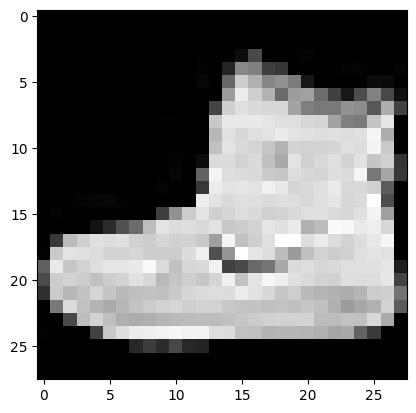

In [37]:
plt.imshow(image.squeeze(), cmap="gray");

In [38]:
rand_image_tensor = torch.randn_like(image)
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [39]:
model_2(rand_image_tensor.unsqueeze(0))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], grad_fn=<AddmmBackward0>)

### 7.1 Stepping through `nn.Conv2d()`

See the documentation for `nn.Conv2d()` here - https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html 

In [40]:
torch.manual_seed(42)

# Create a batch of images
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Test image:\n {test_image}")


Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0

In [41]:
# Create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=0)

# Pass the data through the convolutional layer
conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([10, 62, 62])

### 7.2 Stepping through `nn.MaxPool2d()`

https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

In [42]:
test_image.shape

torch.Size([3, 64, 64])

In [43]:
# Print out ooriginal image without unsqueezed dimension
print(f"Test image original: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(0).shape}")

# Create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max_pool_layer
test_image_through_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through max_pool_layer(): {test_image_through_max_pool.shape}")

Test image original: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through max_pool_layer(): torch.Size([1, 10, 31, 31])


In [44]:
torch.manual_seed(42)

# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1,1,2,2))
print(f"\nRandom tensor:\n {random_tensor}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n {max_pool_tensor}")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")


Random tensor:
 tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])

Max pool tensor:
 tensor([[[[0.3367]]]])
Max pool tensor shape: torch.Size([1, 1, 1, 1])


### 7.3 Setup a loss function and optimizer for `model_2`

In [45]:
# Setup loss function/eval metrics/optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)


In [46]:
model_2.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]],
              
              
      

### 7.4 Training and testing `model_2` using our training and test functions

In [47]:
# Import tqdm for progress bars
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
NUM_EPOCHS = 3

for epoch in tqdm(range(NUM_EPOCHS)):
    ### Training
    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    
    ### Testing
    test_step(model=model_2,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
    
# Calculate total training time
train_time_end_on_cpu = timer()

total_train_time_model_2 = print_train_time(train_time_start_on_cpu, train_time_end_on_cpu, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.59017 | Train acc: 78.63%


 33%|███▎      | 1/3 [00:23<00:47, 23.80s/it]

Test loss: 0.40196 | Test acc: 85.68%
Train loss: 0.35938 | Train acc: 87.13%


 67%|██████▋   | 2/3 [00:48<00:24, 24.05s/it]

Test loss: 0.34902 | Test acc: 87.11%
Train loss: 0.32117 | Train acc: 88.28%


100%|██████████| 3/3 [01:10<00:00, 23.53s/it]

Test loss: 0.33987 | Test acc: 87.81%
Train time on cpu: 70.583 seconds


In [48]:
# Get model_2 results
model_2_results = eval_model(model=model_2,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

model_2_results

100%|██████████| 313/313 [00:01<00:00, 169.68it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3398680090904236,
 'model_acc': 87.80950479233226}

In [49]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 8. Compare model results and training time 

In [50]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.690066,74.810304
2,FashionMNISTModelV2,0.339868,87.809505


In [51]:
# Add training times to compare_results
compare_results['train_time']=[total_train_time_model_0, total_train_time_model_1, total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,train_time
0,FashionMNISTModelV0,0.476639,83.426518,10.567666
1,FashionMNISTModelV1,0.690066,74.810304,10.765971
2,FashionMNISTModelV2,0.339868,87.809505,70.583333


Text(0, 0.5, 'Model')

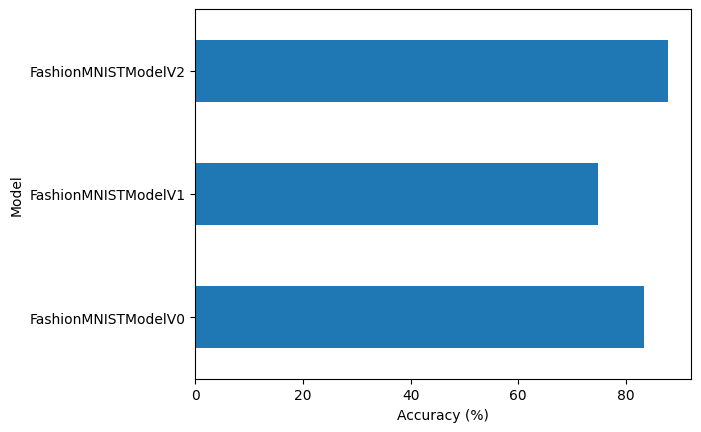

In [52]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("Accuracy (%)")
plt.ylabel("Model")

## 9. Make and evaluate random predictions with best model

In [53]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device):
    
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample (add a batch dimension and move to target device)
            sample = sample.unsqueeze(dim=0).to(device)

            # Forward pass
            pred_logit = model(sample)

            # Get the predicted probability
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off the GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs list into a single tensor
    return torch.stack(pred_probs)


In [54]:
import random
# random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Pullover')

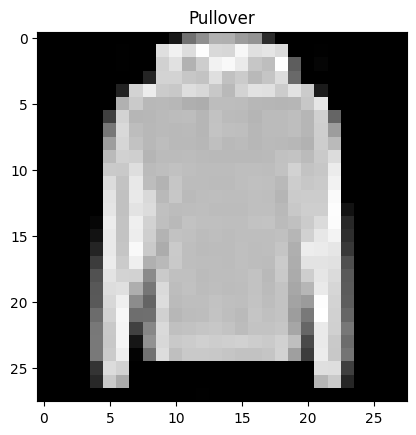

In [55]:
plt.imshow(test_samples[0].squeeze(), cmap='gray')
plt.title(class_names[test_labels[0]])

In [56]:
# Make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples,
                              device=device)

# View first two prediction probabilities
pred_probs[:2]

tensor([[3.4148e-04, 1.8251e-05, 2.4236e-01, 3.2424e-05, 7.5636e-01, 4.5209e-06,
         8.2108e-04, 1.4996e-06, 4.8566e-05, 1.1599e-05],
        [1.6939e-01, 5.6491e-03, 7.3081e-04, 7.5859e-01, 1.4984e-04, 5.0126e-04,
         6.3844e-02, 8.6177e-05, 7.8669e-04, 2.7708e-04]])

In [57]:
# Convert prediction probabilities to class labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([4, 3, 7, 1, 0, 0, 8, 0, 1])

In [58]:
test_labels

[2, 6, 7, 1, 0, 0, 8, 0, 1]

In [59]:
test_samples[0].shape

torch.Size([1, 28, 28])

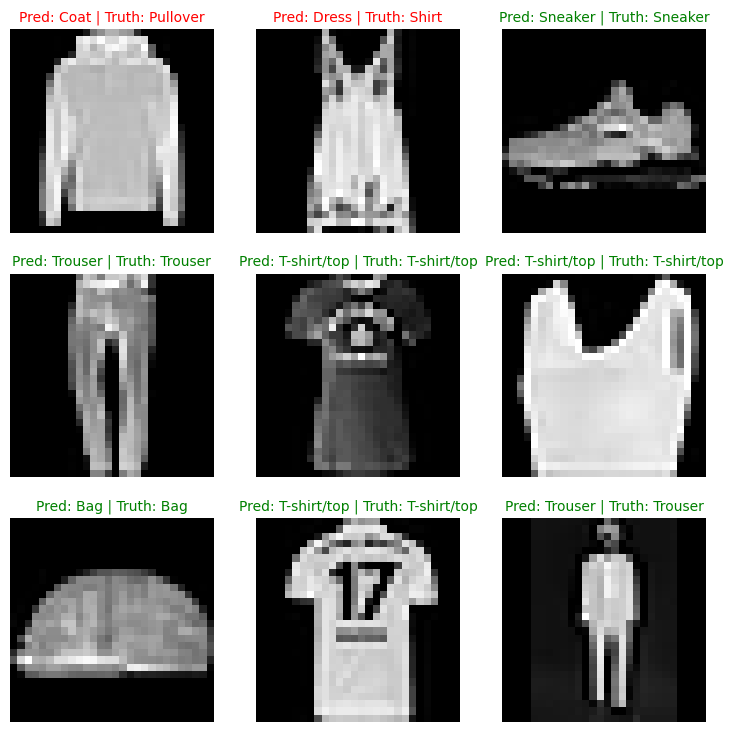

In [60]:
# Plot predictions

fig = plt.figure(figsize=(9,9))
rows, columns = 3, 3

for i, sample in enumerate(test_samples):

    # Create a subplot
    plt.subplot(rows, columns, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap='gray')

    # Find the prediction (in text form, e.g "Sandal")
    pred_label = class_names[pred_classes[i]]

    # Find the true label
    sample_label = class_names[test_labels[i]]

    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {sample_label}"

    if pred_label == sample_label:
        plt.title(title_text, fontsize=10, color='green')
    else:
        plt.title(title_text, fontsize=10, color='red')

    # Turn off the axis
    plt.axis(False)

## 10. Making a confusion matrix for further prediction evaluation 

A confusion matrix is a fantastic way of evaluating your classification models visually: https://www.learnpytorch.io/02_pytorch_classification/#9-more-classification-evaluation-metrics

1. Make predictions with our trained model on the test dataset
2. Make a confusion matrix `torchmetrics.ConfusionMatrix` - https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()` - http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/ 

In [61]:
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc = "Making predictions..."):
        # Move data to device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_logits = model_2(X)

        # Turn predictions from logits -> predictions probabilities -> class labels
        y_pred = torch.softmax(y_logits, dim=0).argmax(dim=1)

        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())

# Concatenate list of predictions into single tensor
# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making predictions...: 100%|██████████| 313/313 [00:01<00:00, 173.02it/s]


tensor([9, 2, 1,  ..., 8, 1, 7])

In [62]:
y_pred_tensor.shape

torch.Size([10000])

In [ ]:
# See if required packages are installed and if not, install them...
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1] >= 19, "mlxtend version should be 0.19.0 or higher")
except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.4
mlxtend version: 0.23.4


In [68]:
import mlxtend
print(mlxtend.__version__)

0.23.4


In [69]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

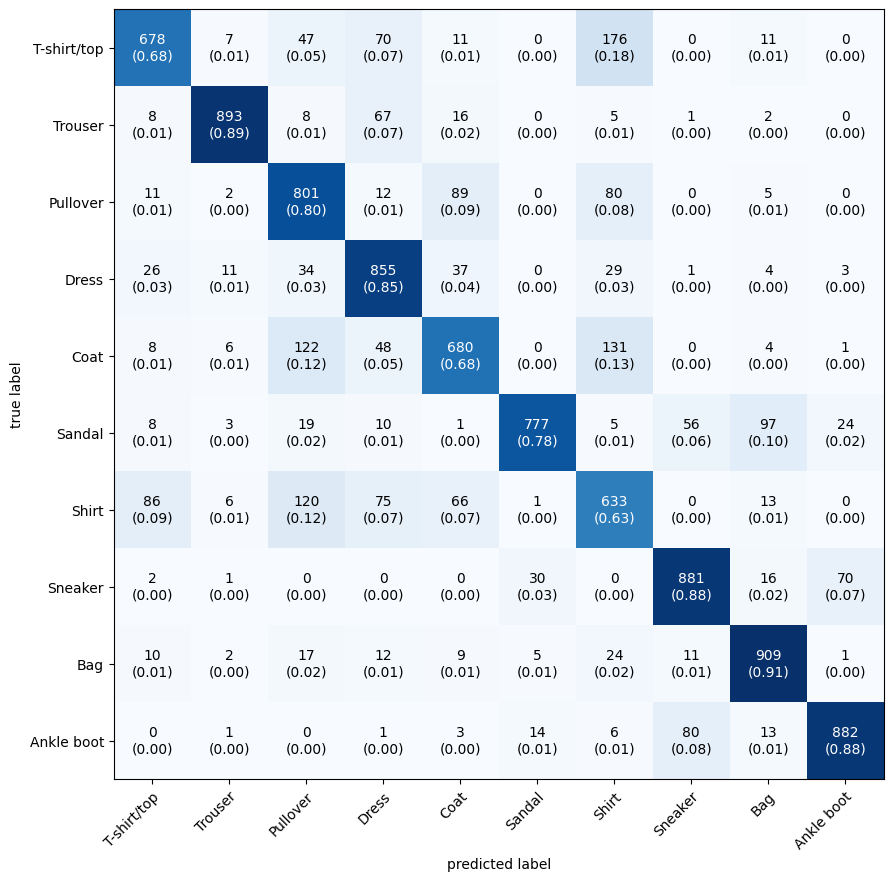

In [77]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names),
                          task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion metrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                figsize=(10,10),
                                class_names=class_names,
                                show_normed=True)


In [78]:
confmat_tensor

tensor([[678,   7,  47,  70,  11,   0, 176,   0,  11,   0],
        [  8, 893,   8,  67,  16,   0,   5,   1,   2,   0],
        [ 11,   2, 801,  12,  89,   0,  80,   0,   5,   0],
        [ 26,  11,  34, 855,  37,   0,  29,   1,   4,   3],
        [  8,   6, 122,  48, 680,   0, 131,   0,   4,   1],
        [  8,   3,  19,  10,   1, 777,   5,  56,  97,  24],
        [ 86,   6, 120,  75,  66,   1, 633,   0,  13,   0],
        [  2,   1,   0,   0,   0,  30,   0, 881,  16,  70],
        [ 10,   2,  17,  12,   9,   5,  24,  11, 909,   1],
        [  0,   1,   0,   1,   3,  14,   6,  80,  13, 882]])

## 11. Save and load best performing model

In [81]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parents if they don't exist
                 exist_ok=True) # don't raise an error if the folder exists

# Create model save
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model state dict to: {MODEL_SAVE_PATH}")
torch.save(model_2.state_dict(), MODEL_SAVE_PATH)

Saving model state dict to: models\03_pytorch_computer_vision_model_2.pth


In [84]:
# Create a new instance of the model
torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelV2(input_shape=image.shape[0],
                                     hidden_units=10,
                                     output_shape=len(class_names)).to(device)

# Load the model state dict
loaded_model_2.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Send the model to target device
loaded_model_2.to(device)

C:\Users\esteb\AppData\Local\Temp\ipykernel_27292\3619838373.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_2.load_state_dict(torch.load(MODEL_SAVE_PATH))


FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [85]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3398680090904236,
 'model_acc': 87.80950479233226}

In [86]:
# Evaluate the loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(model=loaded_model_2,
                                    data_loader=test_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn)

loaded_model_2_results

100%|██████████| 313/313 [00:01<00:00, 171.94it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3398680090904236,
 'model_acc': 87.80950479233226}

In [88]:
# Check if model results are close to each other
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-4)

tensor(True)